In [1]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/home/andrea/ownCloud2/laptop/pycharmProject1/')

import utils.function_library 
importlib.reload(utils.function_library)

from utils.function_library import *
from itertools import combinations
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#number of cosmological parameters
N_parameters = 10

# THEORY VECTOR
mu_cosmolike = np.reshape(np.load("../CosmoCov/covs/xipm/Class3.0_closer_derivative/vector_xipm_kids_Class3.0_closer_derivative.npy"), (-1, 1))

# THEORY COVARIANCE MATRIX
sigma = np.load("../Output/covmats/CovMatrix_class3.0_closer_derivative.npy")

#DATA VECTOR
kids_file = np.loadtxt("../KiDS1000_cosmis_shear_data_release/data_fits/data_xipm")
data_xipm = np.reshape(kids_file[:,1], (-1,1))
Ndim = len(data_xipm)

#DATA COVARIANCE MATRIX
sigma_kids = np.loadtxt("../KiDS1000_cosmis_shear_data_release/data_fits/kids_covariance_matrix")

#Inifile
cosmolike_inifile = "../CosmoCov/covs/ini_files/cov_kids_xipm_runs.ini"

# cosmological parameters
cosmo_params = get_cosmological_parameters(cosmolike_inifile, N_parameters)
params_without_bestfit = dict.fromkeys(['Omega_v', 'w0', 'wa', 'IA'])
list(map(cosmo_params.pop, params_without_bestfit))

#1sigma errors
# make another function of this for the plot
omega_m_symerr = 0.5*(0.065+0.033)
sigma8_symerr = 0.5*(0.084+0.107)
n_s_symerr = 0.5*(0.093+0.049)
omega_b_symerr = 0.5*(0.005+0.000)#Omega_b*h**2 = 0.046*h**2
h_symerr = 0.5*(0.110+0.001)
A_ia_symerr = 0.5 *(0.321 + 0.374)
bestfit_sigmas = [omega_m_symerr, sigma8_symerr, n_s_symerr, omega_b_symerr, h_symerr, A_ia_symerr]
label_list = [r"$\Omega_m$", r"$\sigma_8$", r"$n_s$", r"$\Omega_b$", r"$h$", r"$A_ia$"]

#load Xmatrix
Xmatrix = np.load('X_class3.0_closer_derivative.npy')

### Parameter priors

Put cell above within Fisher function

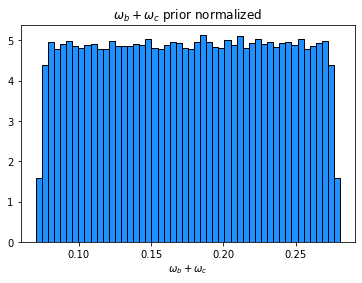

In [3]:
h = [0.64, 0.82]
omega_ch2 = [0.051, 0.255]
omega_bh2 = [0.019, 0.026]
S8 = [0.1, 1.3]
n_s = [0.84, 1.1]
A_ia = [-6,6]

h_uniform = np.random.uniform(h[0], h[1], 100000)

omch2_uniform = np.random.uniform(omega_ch2[0], omega_ch2[1], 100000)
ombh2_uniform = np.random.uniform(omega_bh2[0], omega_bh2[1], 100000)
Omegab_uniform = ombh2_uniform/h_uniform**2

Omegam_uniform = (omch2_uniform + ombh2_uniform)/(h_uniform**2)

S8_uniform = np.random.uniform(S8[0], S8[1], 100000)
sigma8_uniform = S8_uniform/np.sqrt(Omegam_uniform/0.3)

Aia_uniform = np.random.uniform(A_ia[0], A_ia[1], 100000)

Ns_uniform = np.random.uniform(n_s[0], n_s[1], 100000)
plt.title('$\omega_b+\omega_c$ prior normalized ')
plt.xlabel(r'$\omega_b+\omega_c$')
plt.hist(omch2_uniform + ombh2_uniform, 50, density=True, color='Dodgerblue', edgecolor='black')

parameter_priors = np.vstack(( Omegam_uniform, sigma8_uniform, Ns_uniform, Omegab_uniform, h_uniform, Aia_uniform))
#parameter_priors = np.vstack(( Omegam_uniform, sigma8_uniform, Ns_uniform, Omegab_uniform, h_uniform))
#fisher_sigmas = standardDeviation_Fisher(Xmatrix.T, sigma)
#print(fisher_sigmas)

#https://machinelearningmastery.com/introduction-to-expected-value-variance-and-covariance/
# To check that np.var and np.cov are computing (co)variances as intended
#Note: by default, var() is the population variance

## Fisher Contour plots

For the original generic code, see https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/#rating-37

(also contains lines to plot 3d surface and projection)

In [4]:
#without inv in fisher matrix !!! corrected in python file
prior_covariances = np.cov(parameter_priors)
precision_matrix = inv(inv(prior_covariances) + fisher_matrix(Xmatrix.T, sigma))
fisher_sigmas = np.sqrt(np.diag(precision_matrix))
print(fisher_sigmas)

[0.03257399 0.03218478 0.04271092 0.00621194 0.0436107  0.07254788]


In [5]:
mean = [cosmo_params[i] for i in cosmo_params]
right_limit = mean + 2.5*np.array(fisher_sigmas)
left_limit = mean - 2.5*np.array(fisher_sigmas)

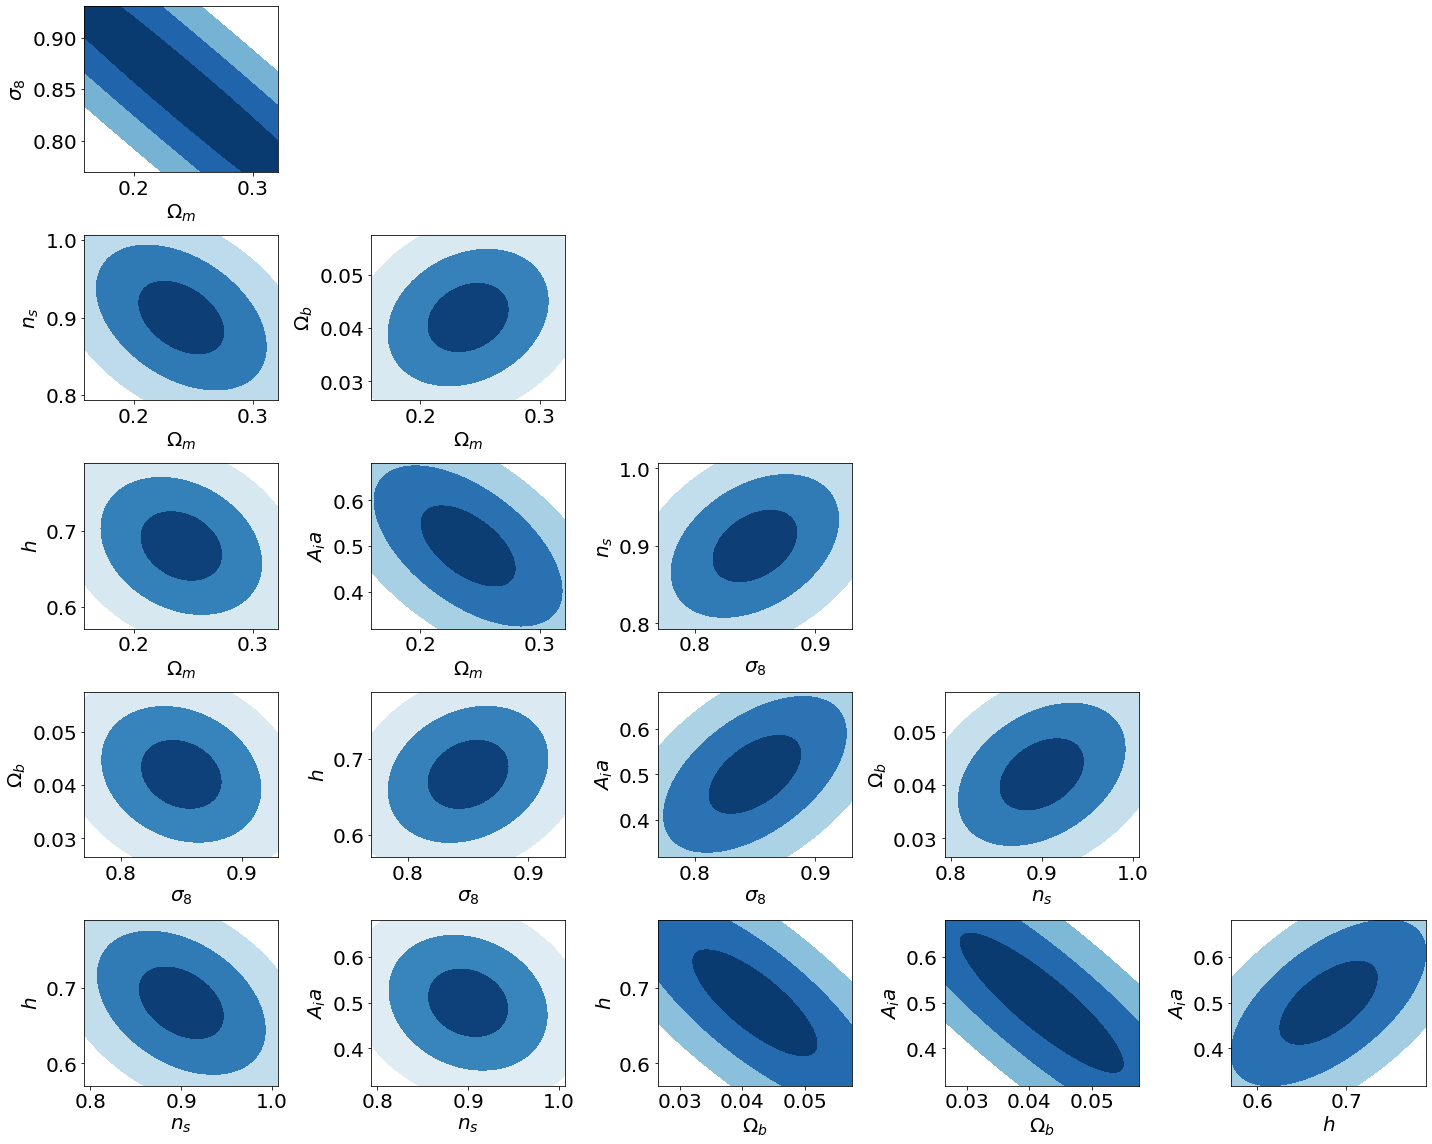

In [10]:
# Our 2-dimensional distribution will be over variables X and Y

a = 5  # number of rows
b = 5  # number of columns
N = 1000
c = [1,6,7,11,12,13,16,17,18,19,21,22,23,24,25]
marginal_pairs = list(combinations(np.arange(6),2))

fig = plt.figure(figsize=(20,16),)
axes = plt.gca()

for i in range(len(c)):
    m, n = marginal_pairs[i]
    x = np.linspace(left_limit[m], right_limit[m], N)
    y = np.linspace(left_limit[n], right_limit[n], N)
    X, Y = np.meshgrid(x, y)

    # Mean vector and covariance matrix
    mu = np.array([mean[m], mean[n]])
    Sigma = np.array([ [precision_matrix[m,m], precision_matrix[m,n]],
                        [precision_matrix[n,m], precision_matrix[n,n]] ])

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)
    
    # Contours at 1sigma's and 2sigma's
    z0 = multivariate_gaussian(mu, mu, Sigma)
    z1 = multivariate_gaussian(mu+np.array([np.sqrt(precision_matrix[m,m]),0]), mu, Sigma)
    z2 = multivariate_gaussian(mu+np.array([2*np.sqrt(precision_matrix[m,m]),0]), mu, Sigma)
    z3 = multivariate_gaussian(mu+np.array([3*np.sqrt(precision_matrix[m,m]),0]), mu, Sigma)

    #print(z0,z1,z2,z3) 
    
    # Create a contour plot 
    plt.subplot(a, b, c[i])
    plt.xlabel(label_list[m], fontsize=20)
    plt.ylabel(label_list[n], fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
                       
    plt.contourf(X, Y, Z, [z3,z2,z1,z0], norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='RdBu')
    #plt.plot(center[m], center[n], '.')    
    
plt.subplots_adjust(top = 0.98, bottom = 0.02, right = 1, left = 0, hspace = 0.07, wspace = 0.05)
fig.tight_layout()
fig.savefig('fisher_contours_closerDerivative.pdf')

Function from https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/#rating-37

In [ ]:
# With scipy.stats
"""
from scipy.stats import multivariate_normal
F = multivariate_normal(mu, Sigma)
Z = F.pdf(pos)

z0 = F.pdf(mu)

z1 = F.pdf(np.array([mu[0]+1.*Sigma[0,0]**(0.5), mu[1]]))

z2 = F.pdf(np.array([mu[0], mu[1]+2.*Sigma[1,1]**(0.5)]))
"""